In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import time 
import gpytorch
from gpytorch.functions import pivoted_cholesky

from gpytorch.kernels import ScaleKernel, MaternKernel, RBFKernel
from gpytorch.priors import GammaPrior
from gpytorch.likelihoods import GaussianLikelihood
import torch
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
# Set device and global dtype
device = "cuda:0"
global_dtype = torch.float32

# Ensure reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Add project source path
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)

# Import custom modules
from gps import CholeskyGaussianProcess, IterativeGaussianProcess
from util import train, eval, plot_gpr_results, fetch_uci_dataset, memory_dump
from plotting import plot_gp_simple, plot_gp_sample, plot_gp_simple_regions

# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2
train_x, train_y, test_x, test_y = fetch_uci_dataset('bike',r"C:\Users\fredw\chris\Research\softki\data\uci_datasets\uci_datasets\elevators\data.csv",train_frac=1/10,val_frac=0)
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
print(train_x.shape)

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode
SIZE (16599, 19)
Dataset loaded
torch.Size([1659, 17])


### Single testing 

---

In [9]:
import torch
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
from preconditioners import build_cholesky,_pivoted_cholesky
from mbcg import init_cg,cond_fn

def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)
    model.fit(train_x, train_y)

    # optimizer = torch.optim.Adam([
    #     {'params': model.kernel.parameters()}, 
    #     {'params': [model.noise.u]}  # Use raw_value instead of noise()
    # ], lr=lr)
    # runtime_log, mll_loss_log, test_rmse_log = [], [], []
    # for i in tqdm(range(training_iterations)):
    #     start_time = time.time()
    #     optimizer.zero_grad()
        
    #     model.fit(train_x, train_y)
    #     loss = model.compute_mll(train_y)
    #     loss.backward()
    #     optimizer.step()
    #     # scheduler.step()  # Update the learning rate

    #     # print(loss)
    #     mean,covar = model.predict(test_x)
    #     total_time = time.time() - start_time
    #     runtime_log.append(total_time)
    #     mll_loss_log.append(-loss.item())
        
    #     test_rmse = (torch.mean(torch.abs(mean.detach().cpu() - test_y))).item()
    #     test_rmse_log.append(test_rmse)
    #     if (i + 1) % 20 == 0:
    #         print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    # return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar


def run_igp_training():
    # Set up the base and scaled kernel for the IGP
    base_kernel_igp = MaternKernel(ard_num_dims=train_x.shape[-1], 
                                   lengthscale_prior=GammaPrior(-3.0, 3.0), 
                                   nu=1.5)
    kernel_igp = ScaleKernel(base_kernel_igp, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
    
    # Initialize the Iterative Gaussian Process model with the desired parameters
    igp_model = IterativeGaussianProcess(
        kernel=kernel_igp, 
        noise=0.4, 
        dtype=global_dtype, 
        device=device,
        cg_tol=1e-3, 
        cg_max_iter=100, 
        warm_start=False, 
        num_probes=16,
        precon_type="identity", 
        trace_backend="Hutch",
        verbose=False, 
        track_iterations=True, 
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )
    
    training_iterations = 1
    lr = 0.01

    print("Training Iterative Gaussian Process (IGP)")
    # Train the IGP model and capture relevant outputs2
    results = train2(igp_model, train_x, train_y, test_x, test_y, training_iterations, lr)
    return results

# Set up the line profiler
lp = LineProfiler()
from mbcg import take_cg_step
# from preconditioners import _pivoted_cholesky
# Add the main training function and key IGP class methods you want to profile.
# Here we add the train function, and as an example, the forward method of IterativeGaussianProcess.
lp.add_function(train2)
lp.add_function(take_cg_step)
lp.add_function(build_cholesky)
lp.add_function(_pivoted_cholesky)
lp.add_function(cond_fn)
lp.add_function(init_cg
)
lp.add_function(IterativeGaussianProcess.forward)
lp.add_function(IterativeGaussianProcess.fit)
lp.add_function(IterativeGaussianProcess.get_preconditioner)

# If there are other important methods (for example, an 'optimize' method), add them similarly:
# lp.add_function(IterativeGaussianProcess.optimize)

# Wrap the IGP training run with the profiler and execute it.
lp_wrapper = lp(run_igp_training)
results = lp_wrapper()

# Print out the profiling statistics.
lp.print_stats()

Training Iterative Gaussian Process (IGP)
Timer unit: 1e-07 s

Total time: 4.30348 s
File: C:\Users\fredw\AppData\Local\Temp\ipykernel_22260\3489855409.py
Function: train2 at line 7

Line #      Hits         Time  Per Hit   % Time  Line Contents
     7                                           def train2(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
     8         1    7885635.0    8e+06     18.3      model.fit(train_x, train_y)
     9         1    8663769.0    9e+06     20.1      model.fit(train_x, train_y)
    10         1    8722202.0    9e+06     20.3      model.fit(train_x, train_y)
    11         1    9064557.0    9e+06     21.1      model.fit(train_x, train_y)
    12         1    8698611.0    9e+06     20.2      model.fit(train_x, train_y)
    13                                           
    14                                               # optimizer = torch.optim.Adam([
    15                                               #     {'params': model.ke

### Single testing igp vs cgp

---

c:\Users\fredw\chris\Research\RandomIterativeGP\randomGP2\code\gps.py:345: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  quadratic = y.T @ self.alpha


tensor(2011.7644, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2009.6201, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2011.9879, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2008.2029, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2006.1985, device='cuda:0', grad_fn=<MulBackward0>)
=== AVERAGED PERFORMANCE METRICS OVER 5 RUNS (Baseline: Cholesky GP) ===
------------------------------------------------------------
Cholesky GP Fit Time         : 0.0327 sec  (Baseline)
Iterative GP Fit Time        : 0.0643 sec
Fit Time Difference          : -0.0316 sec  (-96.76%)
Speedup Factor               : 0.51×
------------------------------------------------------------
Cholesky GP Prediction Time  : 0.0152 sec  (Baseline)
Iterative GP Prediction Time : 0.0044 sec
Prediction Time Difference   : 0.0108 sec  (+71.05%)
Speedup Factor               : 3.45×
------------------------------------------------------------
Cholesky GP Total Time       : 0.0479 sec  (Baseline)
Iterative GP Total Tim

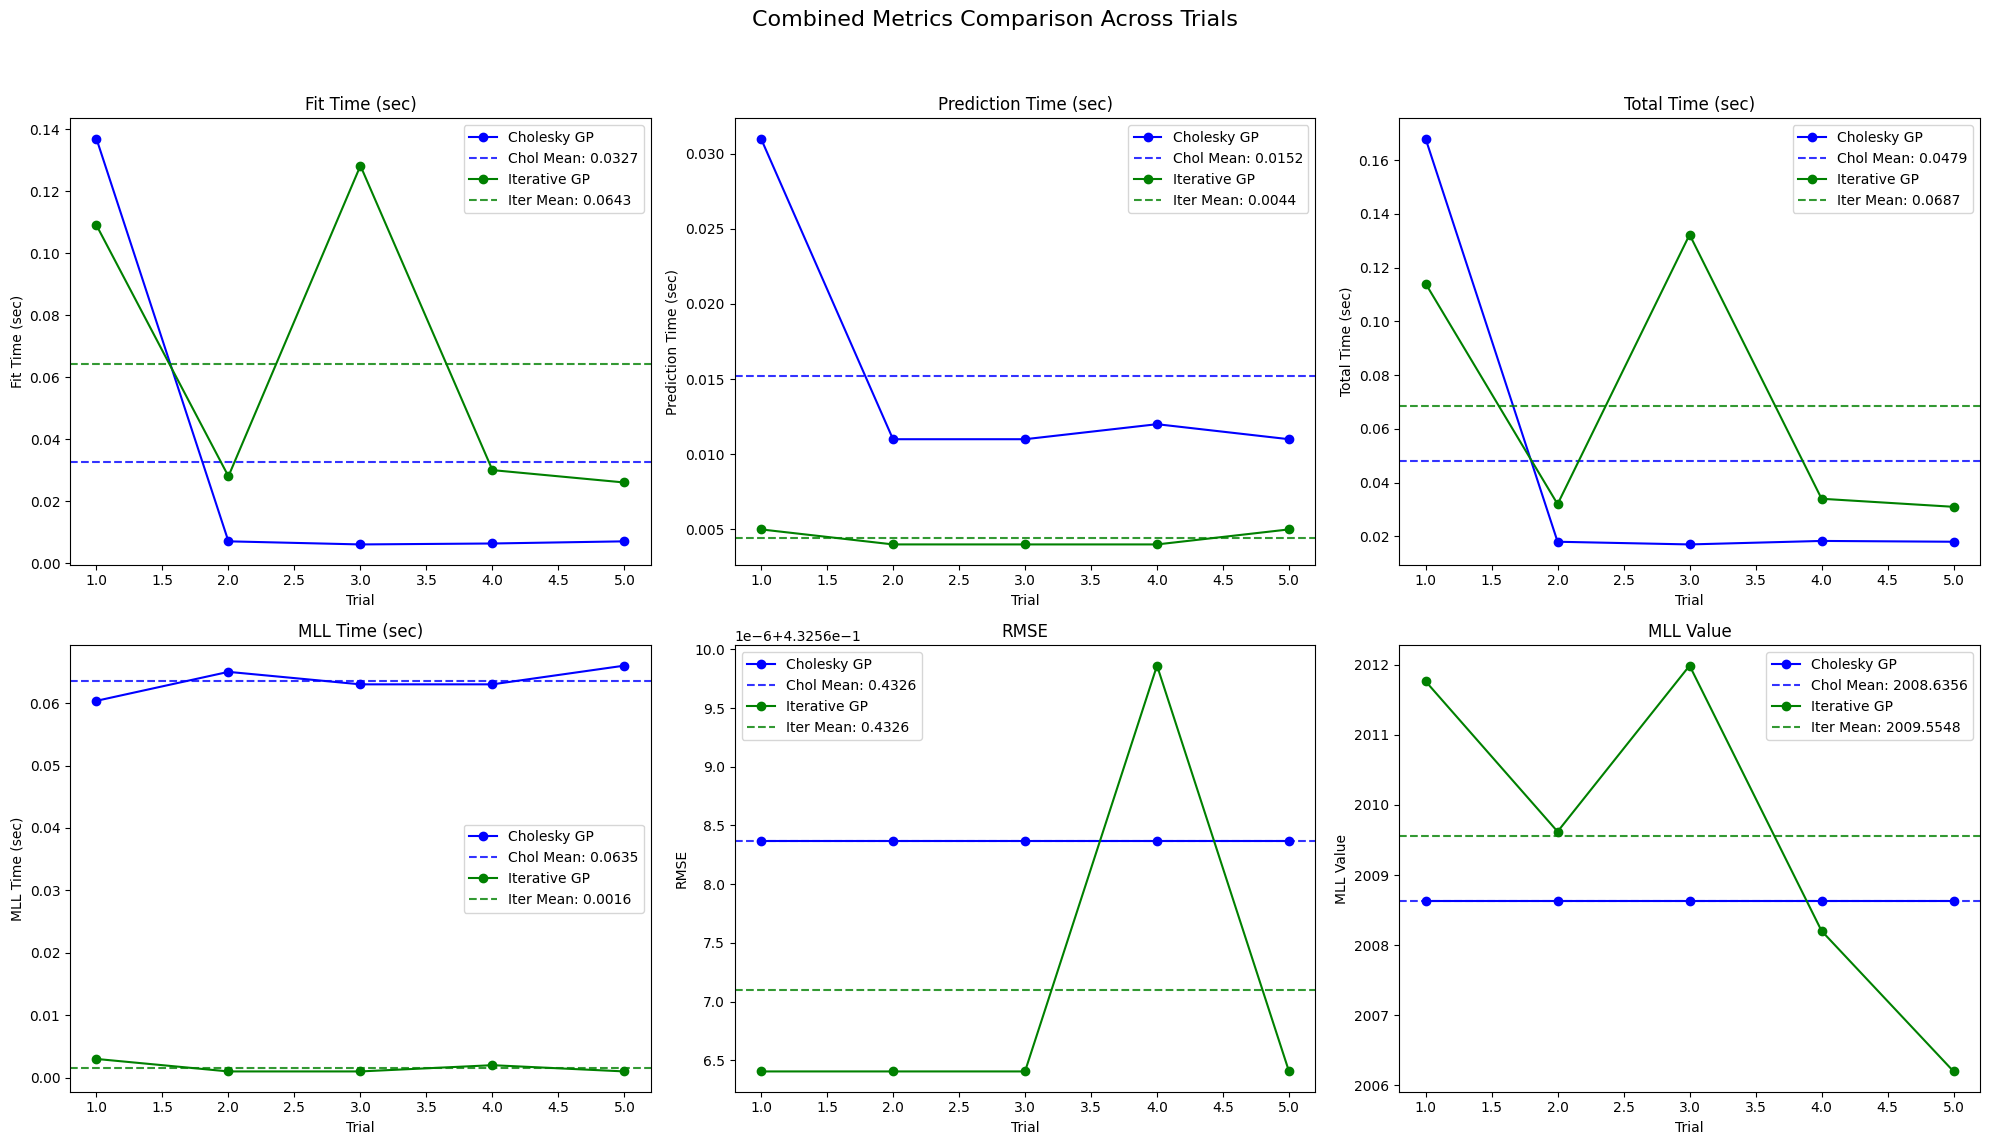

In [2]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming the following GP classes and kernels are defined elsewhere:
# MaternKernel, GammaPrior, ScaleKernel, CholeskyGaussianProcess, IterativeGaussianProcess

def run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    base_kernel = MaternKernel(
        ard_num_dims=train_x.shape[-1],
        lengthscale_prior=GammaPrior(3.0, 6.0),
        nu=1.5,
        compute_covariance=False
    )
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
    gpr = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)
    
    # Fit GP
    start_fit = time.time()
    gpr.fit(train_x, train_y)
    chol_fit_time = time.time() - start_fit

    # Prediction
    start_pred = time.time()
    chol_mean, GP_covariance = gpr.predict(test_x)
    chol_pred_time = time.time() - start_pred

    # MLL computation
    startmll = time.time()
    chol_mll_value = gpr.compute_mll(train_y)
    chol_mll_time = time.time() - startmll

    chol_total_time = chol_fit_time + chol_pred_time
    chol_rmse = torch.mean(torch.abs(chol_mean.detach().cpu() - test_y)).item()

    # Clean up intermediate objects to free memory between runs
    del gpr, kernel, base_kernel, chol_mean, GP_covariance
    torch.cuda.empty_cache()
    
    return chol_total_time, chol_fit_time, chol_pred_time, chol_rmse, chol_mll_time, chol_mll_value.detach().cpu()

def run_iterative_gp(train_x, train_y, test_x, test_y, device, global_dtype):
    base_kernel = MaternKernel(
        ard_num_dims=train_x.shape[-1],
        lengthscale_prior=GammaPrior(3.0, 6.0),
        nu=1.5
    )
    kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)
    
    igp = IterativeGaussianProcess(
        kernel=kernel,
        noise=0.4,
        dtype=global_dtype,
        device=device,
        cg_tol=1e-3,
        cg_max_iter=20,
        warm_start=False,
        num_probes=16,
        precon_type="identity",
        trace_backend="Hutch",
        verbose=False,
        track_iterations=True,
        pred_lanczos_rank=train_x.shape[0],
        compute_covariance=False
    )
    
    # Fit GP
    start_fit = time.time()
    igp.fit(train_x, train_y)
    iter_fit_time = time.time() - start_fit

    # Prediction
    start_pred = time.time()
    mean, covar = igp.predict(test_x)
    iter_pred_time = time.time() - start_pred
    
    iter_total_time = iter_fit_time + iter_pred_time
    iter_rmse = torch.mean(torch.abs(mean.detach().cpu() - test_y)).item()

    # MLL computation
    startmll = time.time()
    iter_mll_value = igp.compute_mll(train_y)
    iter_mll_time = time.time() - startmll
    print(iter_mll_value)
    # Clean up intermediate objects to free memory between runs
    del igp, kernel, base_kernel, mean, covar
    torch.cuda.empty_cache()
    
    return iter_total_time, iter_fit_time, iter_pred_time, iter_rmse, iter_mll_time, iter_mll_value.detach().cpu()

# Number of runs to average over
num_runs = 5

chol_metrics = []
iter_metrics = []

for _ in range(num_runs):
    chol_metrics.append(run_cholesky_gp(train_x, train_y, test_x, test_y, device, global_dtype))
    iter_metrics.append(run_iterative_gp(train_x, train_y, test_x, test_y, device, global_dtype))
    # Delete any leftover variables between runs
    torch.cuda.empty_cache()

# Convert to numpy arrays for averaging
# Each metric: [total_time, fit_time, pred_time, rmse, mll_time, mll_value]
chol_metrics = np.array(chol_metrics)
iter_metrics = np.array(iter_metrics)

chol_total_avg, chol_fit_avg, chol_pred_avg, chol_rmse_avg, chol_mll_time_avg, chol_mll_value_avg = np.mean(chol_metrics, axis=0)
iter_total_avg, iter_fit_avg, iter_pred_avg, iter_rmse_avg, iter_mll_time_avg, iter_mll_value_avg = np.mean(iter_metrics, axis=0)

fit_speedup = ((chol_fit_avg - iter_fit_avg) / chol_fit_avg) * 100
pred_speedup = ((chol_pred_avg - iter_pred_avg) / chol_pred_avg) * 100
total_speedup = ((chol_total_avg - iter_total_avg) / chol_total_avg) * 100
mll_speedup = ((chol_mll_time_avg - iter_mll_time_avg) / chol_mll_time_avg) * 100

fit_factor = chol_fit_avg / iter_fit_avg if iter_fit_avg != 0 else float('inf')
pred_factor = chol_pred_avg / iter_pred_avg if iter_pred_avg != 0 else float('inf')
total_factor = chol_total_avg / iter_total_avg if iter_total_avg != 0 else float('inf')
mll_factor = chol_mll_time_avg / iter_mll_time_avg if iter_mll_time_avg != 0 else float('inf')

RED = "\033[91m"
GREEN = "\033[92m"
RESET = "\033[0m"

def format_speedup(speedup):
    sign = "+" if speedup >= 0 else "-"
    color = GREEN if speedup >= 0 else RED
    return f"{color}{sign}{abs(speedup):.2f}%{RESET}"

print("=== AVERAGED PERFORMANCE METRICS OVER 5 RUNS (Baseline: Cholesky GP) ===")
print("------------------------------------------------------------")
print(f"Cholesky GP Fit Time         : {chol_fit_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Fit Time        : {iter_fit_avg:.4f} sec")
print(f"Fit Time Difference          : {chol_fit_avg - iter_fit_avg:.4f} sec  ({format_speedup(fit_speedup)})")
print(f"Speedup Factor               : {fit_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP Prediction Time  : {chol_pred_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Prediction Time : {iter_pred_avg:.4f} sec")
print(f"Prediction Time Difference   : {chol_pred_avg - iter_pred_avg:.4f} sec  ({format_speedup(pred_speedup)})")
print(f"Speedup Factor               : {pred_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP Total Time       : {chol_total_avg:.4f} sec  (Baseline)")
print(f"Iterative GP Total Time      : {iter_total_avg:.4f} sec")
print(f"Total Time Difference        : {chol_total_avg - iter_total_avg:.4f} sec  ({format_speedup(total_speedup)})")
print(f"Speedup Factor               : {total_factor:.2f}×")
print("------------------------------------------------------------")
print(f"Cholesky GP MLL Computation  : {chol_mll_time_avg:.4f} sec  (Baseline)")
print(f"Iterative GP MLL Computation : {iter_mll_time_avg:.4f} sec")
print(f"MLL Time Difference          : {chol_mll_time_avg - iter_mll_time_avg:.4f} sec  ({format_speedup(mll_speedup)})")
print(f"Speedup Factor               : {mll_factor:.2f}×")
print("------------------------------------------------------------")
print("=== AVERAGED ACCURACY METRICS OVER 5 RUNS ===")
print(f"Cholesky GP RMSE             : {chol_rmse_avg:.4f}  (Baseline)")
print(f"Iterative GP RMSE            : {iter_rmse_avg:.4f}")
print(f"RMSE Difference              : {iter_rmse_avg - chol_rmse_avg:.4f}")
print("------------------------------------------------------------")
print("=== AVERAGED MLL VALUES OVER 5 RUNS ===")
print(f"Cholesky GP MLL Value        : {chol_mll_value_avg:.4f}  (Baseline)")
print(f"Iterative GP MLL Value       : {iter_mll_value_avg:.4f}")
print(f"MLL Value Difference         : {iter_mll_value_avg - chol_mll_value_avg:.4f}")
print("------------------------------------------------------------")

# Separate bar charts for each metric in a 2x3 grid
metric_labels = ['Fit Time (sec)', 'Prediction Time (sec)', 'Total Time (sec)', 'RMSE', 'MLL Time (sec)', 'MLL Value']
chol_vals = [chol_fit_avg, chol_pred_avg, chol_total_avg, chol_rmse_avg, chol_mll_time_avg, chol_mll_value_avg]
iter_vals = [iter_fit_avg, iter_pred_avg, iter_total_avg, iter_rmse_avg, iter_mll_time_avg, iter_mll_value_avg]

num_runs = chol_metrics.shape[0]
trials = np.arange(1, num_runs + 1)

# Define the metric names and their corresponding indices in the metrics arrays.
# For clarity:
# Fit Time -> index 1, Prediction Time -> index 2, Total Time -> index 0,
# MLL Time -> index 4, RMSE -> index 3, MLL Value -> index 5.
metric_names = ['Fit Time (sec)', 'Prediction Time (sec)', 'Total Time (sec)', 'MLL Time (sec)', 'RMSE', 'MLL Value']
metric_indices = [1, 2, 0, 4, 3, 5]

# Define colors for the two methods.
chol_color = 'blue'
iter_color = 'green'

# Create a 2x3 grid of subplots.
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.flatten()

for i, metric in enumerate(metric_names):
    idx = metric_indices[i]
    chol_values = chol_metrics[:, idx]
    iter_values = iter_metrics[:, idx]
    
    chol_mean = np.mean(chol_values)
    iter_mean = np.mean(iter_values)
    
    ax = axs[i]
    # Plot Cholesky GP values and mean.
    ax.plot(trials, chol_values, marker='o', linestyle='-', color=chol_color, label='Cholesky GP')
    ax.axhline(chol_mean, color=chol_color, linestyle='--',alpha=.8, label=f'Chol Mean: {chol_mean:.4f}')
    
    # Plot Iterative GP values and mean.
    ax.plot(trials, iter_values, marker='o', linestyle='-', color=iter_color, label='Iterative GP')
    ax.axhline(iter_mean, color=iter_color, linestyle='--', alpha=.8,label=f'Iter Mean: {iter_mean:.4f}')
    
    ax.set_title(metric)
    ax.set_xlabel('Trial')
    ax.set_ylabel(metric)
    ax.legend()

fig.suptitle("Combined Metrics Comparison Across Trials", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Training igp vs cgp 

---

  1%|          | 1/100 [00:00<00:16,  6.01it/s]

tensor(2010.5203, device='cuda:0', grad_fn=<MulBackward0>)
tensor(2003.0388, device='cuda:0', grad_fn=<MulBackward0>)


  6%|▌         | 6/100 [00:00<00:05, 16.24it/s]

tensor(1993.2515, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1985.0193, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1980.1278, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1970.4692, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1958.4354, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1952.3833, device='cuda:0', grad_fn=<MulBackward0>)


 11%|█         | 11/100 [00:00<00:04, 18.76it/s]

tensor(1944.1418, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1940.3428, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1930.2433, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1920.4459, device='cuda:0', grad_fn=<MulBackward0>)


 15%|█▌        | 15/100 [00:00<00:04, 18.63it/s]

tensor(1916.6069, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1909.9336, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1898.6094, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1887.3229, device='cuda:0', grad_fn=<MulBackward0>)


 20%|██        | 20/100 [00:01<00:04, 18.83it/s]

tensor(1880.3026, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1867.9186, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1864.1821, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1851.4993, device='cuda:0', grad_fn=<MulBackward0>)
Iter 20/100, Loss: 1851.4993


 23%|██▎       | 23/100 [00:01<00:04, 19.11it/s]

tensor(1846.5835, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1834.4844, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1823.6355, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1817.9912, device='cuda:0', grad_fn=<MulBackward0>)


 28%|██▊       | 28/100 [00:01<00:03, 18.80it/s]

tensor(1807.7869, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1798.0032, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1790.0636, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1779.0712, device='cuda:0', grad_fn=<MulBackward0>)


 30%|███       | 30/100 [00:01<00:03, 18.86it/s]

tensor(1769.9893, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1761.2823, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1759.2944, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1745.6683, device='cuda:0', grad_fn=<MulBackward0>)


 35%|███▌      | 35/100 [00:01<00:03, 18.84it/s]

tensor(1734.4296, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1724.4598, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1715.4390, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1695.5166, device='cuda:0', grad_fn=<MulBackward0>)


 39%|███▉      | 39/100 [00:02<00:03, 18.35it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1701.0986, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1693.7742, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1691.9921, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1680.5187, device='cuda:0', grad_fn=<MulBackward0>)


 43%|████▎     | 43/100 [00:02<00:03, 16.46it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
Iter 40/100, Loss: 1680.5187
tensor(1680.7034, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1670.5107, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1658.3800, device='cuda:0', grad_fn=<MulBackward0>)


 45%|████▌     | 45/100 [00:02<00:03, 16.18it/s]

tensor(1655.3848, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1653.3674, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1649.4561, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1641.1379, device='cuda:0', grad_fn=<MulBackward0>)


 49%|████▉     | 49/100 [00:02<00:03, 15.66it/s]

tensor(1633.7303, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1631.4646, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1625.6801, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.


 53%|█████▎    | 53/100 [00:03<00:03, 15.56it/s]

tensor(1615.4626, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1612.4766, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1605.1147, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1594.0400, device='cuda:0', grad_fn=<MulBackward0>)


 55%|█████▌    | 55/100 [00:03<00:02, 15.04it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1594.2773, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1587.0885, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1582.5558, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.


 59%|█████▉    | 59/100 [00:03<00:02, 14.43it/s]

tensor(1576.4106, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1568.3621, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1559.4188, device='cuda:0', grad_fn=<MulBackward0>)


 61%|██████    | 61/100 [00:03<00:02, 13.95it/s]

Iter 60/100, Loss: 1559.4188
tensor(1552.9641, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1548.7219, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1537.5989, device='cuda:0', grad_fn=<MulBackward0>)


 65%|██████▌   | 65/100 [00:03<00:02, 13.69it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1526.3406, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1520.2024, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1514.1268, device='cuda:0', grad_fn=<MulBackward0>)


 67%|██████▋   | 67/100 [00:04<00:02, 13.25it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1514.5844, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1503.8671, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1499.6904, device='cuda:0', grad_fn=<MulBackward0>)


 71%|███████   | 71/100 [00:04<00:02, 13.27it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1494.7571, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1484.9089, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1476.6244, device='cuda:0', grad_fn=<MulBackward0>)


 75%|███████▌  | 75/100 [00:04<00:01, 13.09it/s]

tensor(1466.1376, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1465.8167, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1447.2814, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.


 77%|███████▋  | 77/100 [00:04<00:01, 13.33it/s]

tensor(1448.9539, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1448.3314, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1446.4315, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.


 81%|████████  | 81/100 [00:05<00:01, 13.36it/s]

tensor(1439.2922, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1434.5569, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
Iter 80/100, Loss: 1434.5569
tensor(1433.3385, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.


 83%|████████▎ | 83/100 [00:05<00:01, 13.28it/s]

tensor(1426.4639, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1420.3752, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1420.5503, device='cuda:0', grad_fn=<MulBackward0>)


 85%|████████▌ | 85/100 [00:05<00:01, 12.92it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1420.9080, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1414.2258, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.


 87%|████████▋ | 87/100 [00:05<00:01, 12.54it/s]

tensor(1408.6921, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1407.6724, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1405.6501, device='cuda:0', grad_fn=<MulBackward0>)


 91%|█████████ | 91/100 [00:06<00:00, 11.69it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1398.1187, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1394.5355, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.


 93%|█████████▎| 93/100 [00:06<00:00, 11.23it/s]

tensor(1392.1104, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1389.9807, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1388.1978, device='cuda:0', grad_fn=<MulBackward0>)


 95%|█████████▌| 95/100 [00:06<00:00, 11.46it/s]

[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1391.2590, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1383.1755, device='cuda:0', grad_fn=<MulBackward0>)


 97%|█████████▋| 97/100 [00:06<00:00, 10.97it/s]

tensor(1379.4171, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1372.5325, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1374.6450, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
tensor(1373.0740, device='cuda:0', grad_fn=<MulBackward0>)
[WARNING] Found NaN/Inf in gradient for kernel.raw_outputscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for kernel.base_kernel.raw_lengthscale; setting to zero.
[WARNING] Found NaN/Inf in gradient for noise.u; setting to zero.
Iter 100/100, Loss: 1373.0740


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(2008.6356, device='cuda:0', grad_fn=<MulBackward0>)


  1%|          | 1/100 [00:00<00:13,  7.45it/s]

tensor(2001.1506, device='cuda:0', grad_fn=<MulBackward0>)


  3%|▎         | 3/100 [00:00<00:08, 10.82it/s]

tensor(1993.5903, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1985.9547, device='cuda:0', grad_fn=<MulBackward0>)


  5%|▌         | 5/100 [00:00<00:07, 12.40it/s]

tensor(1978.2446, device='cuda:0', grad_fn=<MulBackward0>)


  7%|▋         | 7/100 [00:00<00:07, 13.11it/s]

tensor(1970.4507, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1962.5835, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1954.6320, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1946.5991, device='cuda:0', grad_fn=<MulBackward0>)


  9%|▉         | 9/100 [00:00<00:06, 13.82it/s]

tensor(1938.4769, device='cuda:0', grad_fn=<MulBackward0>)


 11%|█         | 11/100 [00:00<00:06, 13.78it/s]

tensor(1930.2734, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1921.9814, device='cuda:0', grad_fn=<MulBackward0>)


 13%|█▎        | 13/100 [00:00<00:06, 13.91it/s]

tensor(1913.6058, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1905.1360, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1896.5784, device='cuda:0', grad_fn=<MulBackward0>)


 15%|█▌        | 15/100 [00:01<00:06, 13.98it/s]

tensor(1887.9377, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1879.1946, device='cuda:0', grad_fn=<MulBackward0>)


 17%|█▋        | 17/100 [00:01<00:05, 14.11it/s]

tensor(1870.3607, device='cuda:0', grad_fn=<MulBackward0>)


 19%|█▉        | 19/100 [00:01<00:05, 14.21it/s]

tensor(1861.4392, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1852.4202, device='cuda:0', grad_fn=<MulBackward0>)


 21%|██        | 21/100 [00:01<00:05, 14.26it/s]

Iter 20/100, Loss: 1852.4202
tensor(1843.3010, device='cuda:0', grad_fn=<MulBackward0>)


 23%|██▎       | 23/100 [00:01<00:05, 14.32it/s]

tensor(1834.0901, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1824.7856, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1815.3811, device='cuda:0', grad_fn=<MulBackward0>)


 25%|██▌       | 25/100 [00:01<00:05, 14.38it/s]

tensor(1805.8826, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1796.2874, device='cuda:0', grad_fn=<MulBackward0>)


 27%|██▋       | 27/100 [00:01<00:05, 14.32it/s]

tensor(1786.5964, device='cuda:0', grad_fn=<MulBackward0>)


 29%|██▉       | 29/100 [00:02<00:04, 14.37it/s]

tensor(1776.8083, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1766.9261, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1756.9442, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1746.8702, device='cuda:0', grad_fn=<MulBackward0>)


 31%|███       | 31/100 [00:02<00:04, 14.33it/s]

tensor(1736.6973, device='cuda:0', grad_fn=<MulBackward0>)


 33%|███▎      | 33/100 [00:02<00:04, 14.37it/s]

tensor(1726.4340, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1716.0734, device='cuda:0', grad_fn=<MulBackward0>)


 35%|███▌      | 35/100 [00:02<00:04, 14.38it/s]

tensor(1705.6200, device='cuda:0', grad_fn=<MulBackward0>)


 37%|███▋      | 37/100 [00:02<00:04, 14.41it/s]

tensor(1695.0771, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1684.4399, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1673.7109, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1662.8958, device='cuda:0', grad_fn=<MulBackward0>)


 39%|███▉      | 39/100 [00:02<00:04, 14.39it/s]

tensor(1651.9904, device='cuda:0', grad_fn=<MulBackward0>)


 41%|████      | 41/100 [00:02<00:04, 14.45it/s]

Iter 40/100, Loss: 1651.9904
tensor(1640.9974, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1629.9203, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1618.7639, device='cuda:0', grad_fn=<MulBackward0>)


 45%|████▌     | 45/100 [00:03<00:03, 14.38it/s]

tensor(1607.5195, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1596.1879, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1584.7826, device='cuda:0', grad_fn=<MulBackward0>)


 47%|████▋     | 47/100 [00:03<00:03, 14.32it/s]

tensor(1573.2947, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1561.7412, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1550.0967, device='cuda:0', grad_fn=<MulBackward0>)


 51%|█████     | 51/100 [00:03<00:03, 14.37it/s]

tensor(1538.3850, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1526.6016, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1514.7493, device='cuda:0', grad_fn=<MulBackward0>)


 55%|█████▌    | 55/100 [00:03<00:03, 14.44it/s]

tensor(1502.8318, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1490.8479, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1478.7896, device='cuda:0', grad_fn=<MulBackward0>)


 57%|█████▋    | 57/100 [00:04<00:02, 14.43it/s]

tensor(1466.6753, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1454.4996, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1442.2653, device='cuda:0', grad_fn=<MulBackward0>)


 59%|█████▉    | 59/100 [00:04<00:02, 14.44it/s]

tensor(1429.9722, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1417.6250, device='cuda:0', grad_fn=<MulBackward0>)
Iter 60/100, Loss: 1417.6250
tensor(1405.2257, device='cuda:0', grad_fn=<MulBackward0>)


 63%|██████▎   | 63/100 [00:04<00:02, 14.44it/s]

tensor(1392.7737, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1380.2710, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1367.7223, device='cuda:0', grad_fn=<MulBackward0>)


 65%|██████▌   | 65/100 [00:04<00:02, 14.38it/s]

tensor(1355.1268, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1342.4873, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1329.8054, device='cuda:0', grad_fn=<MulBackward0>)


 69%|██████▉   | 69/100 [00:04<00:02, 14.28it/s]

tensor(1317.0841, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1304.3243, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1291.5371, device='cuda:0', grad_fn=<MulBackward0>)


 73%|███████▎  | 73/100 [00:05<00:01, 14.19it/s]

tensor(1278.6960, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1265.8313, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1252.9456, device='cuda:0', grad_fn=<MulBackward0>)


 75%|███████▌  | 75/100 [00:05<00:01, 14.25it/s]

tensor(1240.0110, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1227.0573, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1214.0803, device='cuda:0', grad_fn=<MulBackward0>)


 79%|███████▉  | 79/100 [00:05<00:01, 14.32it/s]

tensor(1201.0748, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1188.0490, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1175.0017, device='cuda:0', grad_fn=<MulBackward0>)


 81%|████████  | 81/100 [00:05<00:01, 14.33it/s]

tensor(1161.9351, device='cuda:0', grad_fn=<MulBackward0>)
Iter 80/100, Loss: 1161.9351
tensor(1148.8511, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1135.7504, device='cuda:0', grad_fn=<MulBackward0>)


 85%|████████▌ | 85/100 [00:06<00:01, 14.36it/s]

tensor(1122.6333, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1109.5045, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1096.3645, device='cuda:0', grad_fn=<MulBackward0>)


 87%|████████▋ | 87/100 [00:06<00:00, 14.34it/s]

tensor(1083.2213, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1070.0519, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1056.8857, device='cuda:0', grad_fn=<MulBackward0>)


 91%|█████████ | 91/100 [00:06<00:00, 14.35it/s]

tensor(1043.7100, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1030.5300, device='cuda:0', grad_fn=<MulBackward0>)
tensor(1017.3476, device='cuda:0', grad_fn=<MulBackward0>)


 93%|█████████▎| 93/100 [00:06<00:00, 14.55it/s]

tensor(1004.1639, device='cuda:0', grad_fn=<MulBackward0>)
tensor(990.9773, device='cuda:0', grad_fn=<MulBackward0>)
tensor(977.8030, device='cuda:0', grad_fn=<MulBackward0>)


 95%|█████████▌| 95/100 [00:06<00:00, 14.31it/s]

tensor(964.6165, device='cuda:0', grad_fn=<MulBackward0>)
tensor(951.4244, device='cuda:0', grad_fn=<MulBackward0>)
tensor(938.2444, device='cuda:0', grad_fn=<MulBackward0>)


 99%|█████████▉| 99/100 [00:06<00:00, 14.32it/s]

tensor(925.0695, device='cuda:0', grad_fn=<MulBackward0>)
tensor(911.8987, device='cuda:0', grad_fn=<MulBackward0>)
tensor(898.7374, device='cuda:0', grad_fn=<MulBackward0>)


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


Iter 100/100, Loss: 898.7374


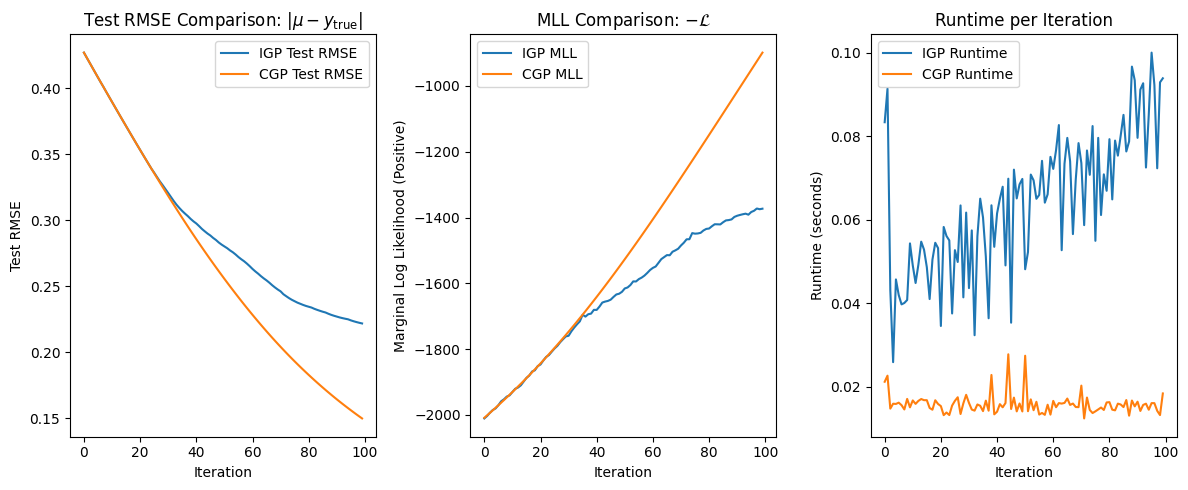

In [5]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
torch.backends.cuda.preferred_linalg_library(backend="cusolver")
def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        
        loss = model.compute_mll(train_y)
        print(loss)
        
        loss.backward()

        # Zero out any NaN or Inf gradients before stepping
        for name, param in model.named_parameters():
            if param.grad is not None:
                nan_mask = torch.isnan(param.grad) | torch.isinf(param.grad)
                if nan_mask.any():
                    print(f"[WARNING] Found NaN/Inf in gradient for {name}; setting to zero.")
                    param.grad[nan_mask] = 0.0
        
        optimizer.step()
        
        mean, covar = model.predict(test_x)
        
        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())  # Logging positive MLL value
        
        test_rmse = torch.mean(torch.abs(mean.detach().cpu() - test_y)).item()
        test_rmse_log.append(test_rmse)
        
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar

# Example usage:
# Assuming that model_igp and model_cgp are instantiated GP models (Iterative GP and Cholesky GP respectively),
# and train_x, train_y, test_x, test_y are already defined.
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)


base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

igp = IterativeGaussianProcess(kernel=kernel, noise=0.4, dtype=global_dtype, device=device,
                               cg_tol=1e-2, cg_max_iter=100, warm_start=False, num_probes=16,
                               precon_type="identity", trace_backend="Hutch",
                               verbose=False, track_iterations=False, 
                               pred_lanczos_rank=train_x.shape[0], compute_covariance=False)
                               
# Train the iterative GP model
epochs= 100
model_igp, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp, mean_igp, covar_igp = train(igp, train_x, train_y, test_x, test_y, training_iterations=epochs, lr=0.01)

# Train the Cholesky-based GP model
model_cgp, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp, mean_cgp, covar_cgp = train(cgp, train_x, train_y, test_x, test_y, training_iterations=epochs, lr=0.01)

# ----------------------------
# Two-Panel Plot: RMSE, MLL, and Runtime
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot RMSE comparison: |μ - yₜᵣᵤₑ|
axes[0].plot(test_rmse_log_igp, label="IGP Test RMSE")
axes[0].plot(test_rmse_log_cgp, label="CGP Test RMSE")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[0].legend()

# Plot MLL comparison: -𝓛 (where a lower negative loss indicates a higher likelihood)
axes[1].plot(mll_loss_log_igp, label="IGP MLL")
axes[1].plot(mll_loss_log_cgp, label="CGP MLL")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[1].set_title(r"MLL Comparison: $-\mathcal{L}$")
axes[1].legend()

# Plot runtime per iteration
axes[2].plot(runtime_log_igp, label="IGP Runtime")
axes[2].plot(runtime_log_cgp, label="CGP Runtime")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Runtime (seconds)")
axes[2].set_title(r"Runtime per Iteration")
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
from torchviz import make_dot


### training igp vs cgp mll

---

Kernel parameters:
Lengthscale: [[0.6931472 0.6931472 0.6931472 0.6931472 0.6931472 0.6931472 0.6931472
  0.6931472 0.6931472 0.6931472 0.6931472 0.6931472 0.6931472 0.6931472
  0.6931472 0.6931472 0.6931472]]
Outputscale: 0.6931472
Noise: 0.39999995
quadratic term igp tensor(1316.4410, device='cuda:0', grad_fn=<DotBackward0>) log det igp tensor(-347.9391, device='cuda:0', grad_fn=<AddBackward0>)
Loss: 2008.77001953125
Gradient update for kernel.raw_outputscale (after zeroing NaNs/Infs):
tensor(74.8701, device='cuda:0')
Gradient update for kernel.base_kernel.raw_lengthscale (after zeroing NaNs/Infs):
tensor([[-6.6930e+01, -6.5465e+01, -6.3855e+01, -3.9352e+01, -5.8473e+01,
         -3.8035e+01, -4.5586e+01, -4.8887e+01, -3.3373e+01, -1.5926e+01,
         -1.4770e+01, -1.4762e+01, -1.4355e+01, -2.9285e+01,  0.0000e+00,
         -1.0264e+01,  1.1727e-06]], device='cuda:0')
Gradient update for noise.u (after zeroing NaNs/Infs):
tensor(111.0391)
Kernel parameters:
Lengthscale: [[0.6981597 

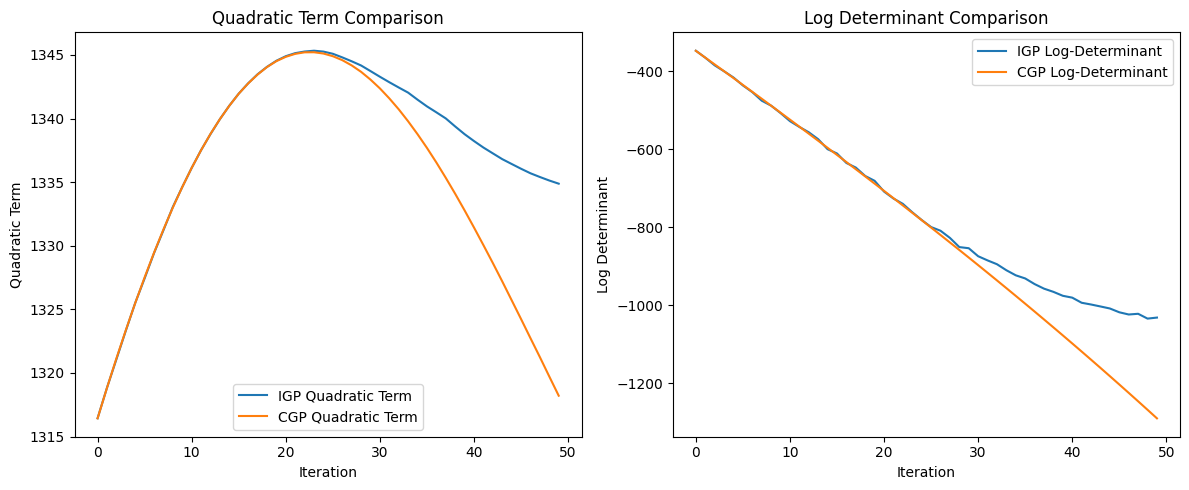

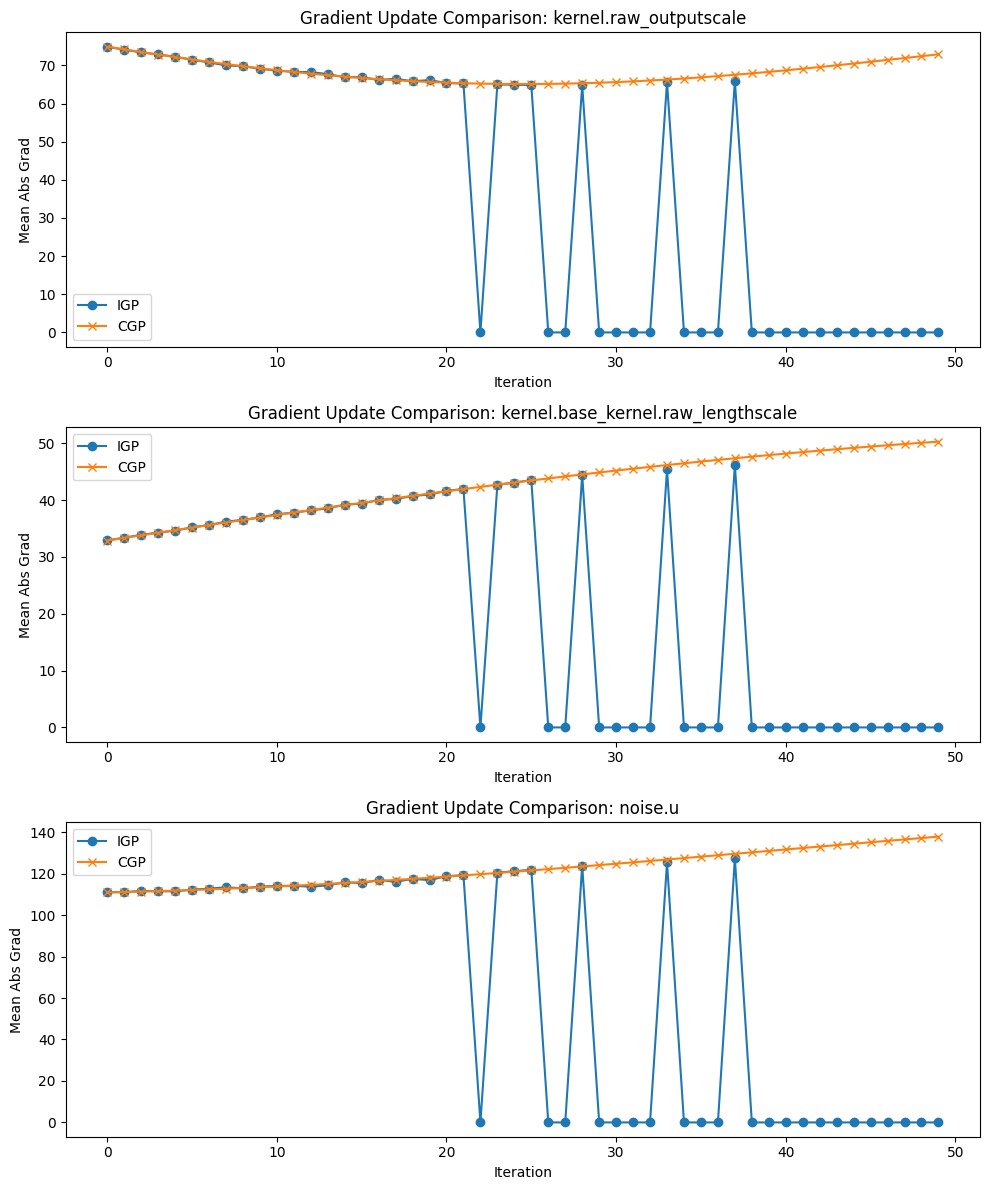

In [3]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1, mll_debug=False):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    
    runtime_log = []
    mll_loss_log = []
    test_rmse_log = []
    debug_quadratic_log = []
    debug_logdet_log = []
    grad_updates_log = []  # To store a dict of gradients per iteration
    
    for i in range(training_iterations):
        start_time = time.time()
        
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        
        print("Kernel parameters:")
        print("Lengthscale:", model.kernel.base_kernel.lengthscale.detach().cpu().numpy())
        print("Outputscale:", model.kernel.outputscale.detach().cpu().numpy())
        print("Noise:", model.noise.get_value().detach().cpu().numpy())

        if mll_debug:
            loss, quadratic_term, log_det_K = model.compute_mll(train_y, mll_debug=True)
            debug_quadratic_log.append(quadratic_term.item())
            debug_logdet_log.append(log_det_K.item())
        else:
            loss = model.compute_mll(train_y)
        
        print("Loss:", loss.item())
        loss.backward()
        
        grad_dict = {}
        for name, param in model.named_parameters():
            if param.grad is not None:
                # Replace NaN or Inf entries in the gradient with zero
                grad_before = param.grad.clone()
                nan_mask = torch.isnan(param.grad) | torch.isinf(param.grad)
                if nan_mask.any():
                    print(f"[WARNING] Found NaN/Inf in gradient for {name}. Zeroing them out.")
                    param.grad[nan_mask] = 0.0
                
                # Optionally print the cleaned-up gradient
                print(f"Gradient update for {name} (after zeroing NaNs/Infs):")
                print(param.grad)
                grad_dict[name] = param.grad.detach().cpu().clone()
        
        grad_updates_log.append(grad_dict)
        optimizer.step()
        
        mean, covar = model.predict(test_x)
        
        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())  # Logging positive MLL value
        
        test_rmse = torch.mean(torch.abs(mean.detach().cpu() - test_y)).item()
        test_rmse_log.append(test_rmse)
        
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return (model, runtime_log, mll_loss_log, test_rmse_log,
            mean, covar, debug_quadratic_log, debug_logdet_log, grad_updates_log)
# ----------------------------
# Example model setup and training
# ----------------------------
# Assuming that train_x, train_y, test_x, test_y are already defined,
# and that MaternKernel, ScaleKernel, GammaPrior, CholeskyGaussianProcess, 
# and IterativeGaussianProcess are properly imported and instantiated.

base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1],
                           lengthscale_prior=GammaPrior(3.0, 6.0),
                           nu=1.5)
kernel = ScaleKernel(base_kernel,
                     outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype,
                              noise=0.4, device=device)

base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1],
                           lengthscale_prior=GammaPrior(3.0, 6.0),
                           nu=1.5)
kernel = ScaleKernel(base_kernel,
                     outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

igp = IterativeGaussianProcess(kernel=kernel, noise=0.4, dtype=global_dtype,
                               device=device, cg_tol=1e-2, cg_max_iter=100,
                               warm_start=False, num_probes=50,
                               precon_type="identity", trace_backend="Hutch",
                               verbose=False, track_iterations=False, 
                               pred_lanczos_rank=train_x.shape[0],
                               compute_covariance=False)

# Train the iterative GP model with mll_debug=True
epochs = 50
(model_igp, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp,
 mean_igp, covar_igp, debug_quadratic_log_igp, debug_logdet_log_igp, grad_updates_log_igp) = train(
    igp, train_x, train_y, test_x, test_y, training_iterations=epochs, lr=0.01, mll_debug=True
)

# Train the Cholesky-based GP model with mll_debug=True
(model_cgp, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp,
 mean_cgp, covar_cgp, debug_quadratic_log_cgp, debug_logdet_log_cgp, grad_updates_log_cgp) = train(
    cgp, train_x, train_y, test_x, test_y, training_iterations=epochs, lr=0.01, mll_debug=True
)

# ----------------------------
# Original Plotting: Quadratic Term and Log-Determinant Comparison
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the quadratic term from the debug output
axes[0].plot(debug_quadratic_log_igp, label="IGP Quadratic Term")
axes[0].plot(debug_quadratic_log_cgp, label="CGP Quadratic Term")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Quadratic Term")
axes[0].set_title(r"Quadratic Term Comparison")
axes[0].legend()

# Plot the log-determinant from the debug output
axes[1].plot(debug_logdet_log_igp, label="IGP Log-Determinant")
axes[1].plot(debug_logdet_log_cgp, label="CGP Log-Determinant")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Log Determinant")
axes[1].set_title(r"Log Determinant Comparison")
axes[1].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# New Plotting: Raw Gradient Update Comparison
# ----------------------------
# Assume both models have the same parameter names
param_names = grad_updates_log_igp[0].keys()

# Create a subplot for each parameter to compare IGP vs. CGP gradients
num_params = len(param_names)
fig2, axes2 = plt.subplots(num_params, 1, figsize=(10, 4 * num_params))
if num_params == 1:
    axes2 = [axes2]

for ax, name in zip(axes2, param_names):
    igp_grad_means = []
    cgp_grad_means = []
    for i in range(epochs):
        grad_igp = grad_updates_log_igp[i][name]
        grad_cgp = grad_updates_log_cgp[i][name]
        # Here we take the mean of the absolute values of the gradients as a summary
        igp_grad_means.append(grad_igp.abs().mean().item())
        cgp_grad_means.append(grad_cgp.abs().mean().item())
    ax.plot(igp_grad_means, marker='o', label="IGP")
    ax.plot(cgp_grad_means, marker='x', label="CGP")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Mean Abs Grad")
    ax.set_title(f"Gradient Update Comparison: {name}")
    ax.legend()

plt.tight_layout()
plt.show()

In [14]:
print("\n--- Data Summary ---")
print("IGP Runtime Log:", runtime_log_igp)
print("IGP MLL Loss Log:", mll_loss_log_igp)
print("IGP Test RMSE Log:", test_rmse_log_igp)
print("IGP Debug Quadratic Log:", debug_quadratic_log_igp)
print("IGP Debug LogDet Log:", debug_logdet_log_igp)

print("CGP Runtime Log:", runtime_log_cgp)
print("CGP MLL Loss Log:", mll_loss_log_cgp)
print("CGP Test RMSE Log:", test_rmse_log_cgp)
print("CGP Debug Quadratic Log:", debug_quadratic_log_cgp)
print("CGP Debug LogDet Log:", debug_logdet_log_cgp)



--- Data Summary ---
IGP Runtime Log: [0.3413577079772949, 0.26738405227661133, 0.2030627727508545, 0.25647544860839844, 0.227494478225708, 0.22177457809448242, 0.23673319816589355, 0.22572875022888184, 0.2232189178466797, 0.1773700714111328, 0.265366792678833, 0.23421645164489746, 0.2611246109008789, 0.22943878173828125, 0.18374919891357422, 0.2231898307800293, 0.2428758144378662, 0.26935386657714844, 0.27854275703430176, 0.27375125885009766, 0.2605881690979004, 0.27481579780578613, 0.28611326217651367, 0.28044795989990234, 0.28998851776123047, 0.2086637020111084, 0.2619163990020752, 0.22427105903625488, 0.22867655754089355, 0.19978976249694824, 0.24608063697814941, 0.2652299404144287, 0.2265009880065918, 0.2297203540802002, 0.24720239639282227, 0.25193238258361816, 0.23089098930358887, 0.18996667861938477, 0.26293110847473145, 0.22910833358764648, 0.18634700775146484, 0.2525978088378906, 0.2548849582672119, 0.2034893035888672, 0.2594318389892578, 0.24053382873535156, 0.1945505142211

In [15]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import gpytorch

# Assume device is defined, e.g., device = torch.device("cuda:0")
# Move your datasets to the specified device
train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

# --- Define the training function for IGP and CGP (unchanged) ---
def train(model, train_x, train_y, test_x, test_y, training_iterations=100, lr=0.1):
    optimizer = torch.optim.Adam([
        {'params': model.kernel.parameters()}, 
        {'params': [model.noise.u]}  # Use raw_value instead of noise()
    ], lr=lr)
    
    runtime_log, mll_loss_log, test_rmse_log = [], [], []
    
    for i in tqdm(range(training_iterations)):
        start_time = time.time()
        
        optimizer.zero_grad()
        model.fit(train_x, train_y)
        loss = model.compute_mll(train_y)
        print(loss)
        loss.backward()
        optimizer.step()
        
        mean, covar = model.predict(test_x)
        
        total_time = time.time() - start_time
        runtime_log.append(total_time)
        mll_loss_log.append(-loss.item())  # Logging positive MLL value
        
        test_rmse = torch.mean(torch.abs(mean - test_y)).item()
        test_rmse_log.append(test_rmse)
        
        if (i + 1) % 20 == 0:
            print(f'Iter {i+1}/{training_iterations}, Loss: {loss.item():.4f}')
    
    return model, runtime_log, mll_loss_log, test_rmse_log, mean, covar

# --- Define the GPyTorch exact GP regression model ---
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Constant mean and a Matern kernel (with $\nu=1.5$) scaled by a learned outputscale
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# --- Instantiate IGP and CGP models (using your provided setup) ---
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

cgp = CholeskyGaussianProcess(kernel=kernel, dtype=global_dtype, noise=0.4, device=device)

base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1], lengthscale_prior=GammaPrior(3.0, 6.0), nu=1.5)
kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(2.0, 0.15)).to(device)

igp = IterativeGaussianProcess(kernel=kernel, noise=0.4, dtype=global_dtype, device=device,
                               cg_tol=1e-2, cg_max_iter=100, warm_start=True, num_probes=16,
                               precon_type="identity", trace_backend="Hutch",
                               verbose=False, track_iterations=False, 
                               pred_lanczos_rank=train_x.shape[0], compute_covariance=False)

# Train the iterative GP model
model_igp, runtime_log_igp, mll_loss_log_igp, test_rmse_log_igp, mean_igp, covar_igp = train(
    igp, train_x, train_y, test_x, test_y, training_iterations=50, lr=0.01)

# Train the Cholesky-based GP model
model_cgp, runtime_log_cgp, mll_loss_log_cgp, test_rmse_log_cgp, mean_cgp, covar_cgp = train(
    cgp, train_x, train_y, test_x, test_y, training_iterations=50, lr=0.01)

# --- Define and train the GPyTorch exact GP model ---
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model_gp = ExactGPModel(train_x, train_y, likelihood).to(device)

model_gp.train()
likelihood.train()
optimizer_gp = torch.optim.Adam(model_gp.parameters(), lr=0.01)
mll_gp = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gp)

# Initialize logs for GPyTorch
runtime_log_gp, mll_loss_log_gp, test_rmse_log_gp = [], [], []
training_iterations = 50  # Using the same number of iterations

for i in tqdm(range(training_iterations)):
    start_time = time.time()
    optimizer_gp.zero_grad()
    output = model_gp(train_x)
    loss = -mll_gp(output, train_y)  # negative MLL to minimize
    loss.backward()
    optimizer_gp.step()
    
    # Switch to evaluation mode for prediction
    model_gp.eval()
    likelihood.eval()
    with torch.no_grad():
        preds = likelihood(model_gp(test_x))
        mean_gp = preds.mean
        test_rmse_gp = torch.mean(torch.abs(mean_gp - test_y)).item()
    
    runtime_log_gp.append(time.time() - start_time)
    mll_loss_log_gp.append(-loss.item())  # Log positive MLL
    test_rmse_log_gp.append(test_rmse_gp)
    
    model_gp.train()
    likelihood.train()

# --- Plotting all three models ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE Comparison: $|\mu - y_{\text{true}}|$
axes[0].plot(test_rmse_log_igp, label="IGP Test RMSE")
axes[0].plot(test_rmse_log_cgp, label="CGP Test RMSE")
axes[0].plot(test_rmse_log_gp, label="GPyTorch Test RMSE")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Test RMSE")
axes[0].set_title(r"Test RMSE Comparison: $|\mu - y_{\text{true}}|$")
axes[0].legend()

# MLL Comparison: $-\mathcal{L}$ (a higher value implies a better likelihood)
axes[1].plot(mll_loss_log_igp, label="IGP MLL")
axes[1].plot(mll_loss_log_cgp, label="CGP MLL")
axes[1].plot(mll_loss_log_gp, label="GPyTorch MLL")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Marginal Log Likelihood (Positive)")
axes[1].set_title(r"MLL Comparison: $-\mathcal{L}$")
axes[1].legend()

# Runtime per Iteration
axes[2].plot(runtime_log_igp, label="IGP Runtime")
axes[2].plot(runtime_log_cgp, label="CGP Runtime")
axes[2].plot(runtime_log_gp, label="GPyTorch Runtime")
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Runtime (seconds)")
axes[2].set_title(r"Runtime per Iteration")
axes[2].legend()

plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 11]) torch.Size([16, 10])
Eigenvalue stats -> min: 2.243e-01, max: 1.043e+01, mean: 3.295e+00
Gamma stats -> min: -2.341e-01, max: -1.869e-01, mean: -2.072e-01
Quadratic term: tensor(1316.3801, device='cuda:0', grad_fn=<DotBackward0>)
Tau star log: tensor(-343.8221, device='cuda:0', grad_fn=<AddBackward0>)
Constant term: tensor(3049.0381, device='cuda:0')
(tensor(2010.7981, device='cuda:0', grad_fn=<MulBackward0>), tensor(1316.3801, device='cuda:0', grad_fn=<DotBackward0>), tensor(-343.8221, device='cuda:0', grad_fn=<AddBackward0>))


AttributeError: 'tuple' object has no attribute 'backward'

### Ideas: plot values of mll quantity,
Also add lanczos to the cholesky  :<